# Resampling your digitized log

Sometimes the only data you have is an image. In order to work with this type of data you need to transform it from analogical into digital format. How did I do that:

- First it was necessary to digitize the data
- I've found a web application that does it very well - WebPlotDigitizer
- After digitizing I needed to resample them to even intervals, to fit with the data I already have

So, this code is meant to help you to fit an analogical data with uneven intervals to digital data with even intervals that you decide the sample interval.

In [1]:
import numpy as np
import las
import lasio
import sys
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

#used for inserting images
from IPython.display import Image 

See below how I digitize my data. The way you digitize will impact in the end at the interpolation algorithm. So, pay attention to pick the spots with maximum and minimum amplitude. You can also pick some intermediate values to give more resolution to your data. Follow the instructions of the program to set up your axes accordingly. With this code I didn't need to digitize the RHOB log, only DT was digitized because RHOB I already have in the .las file. 

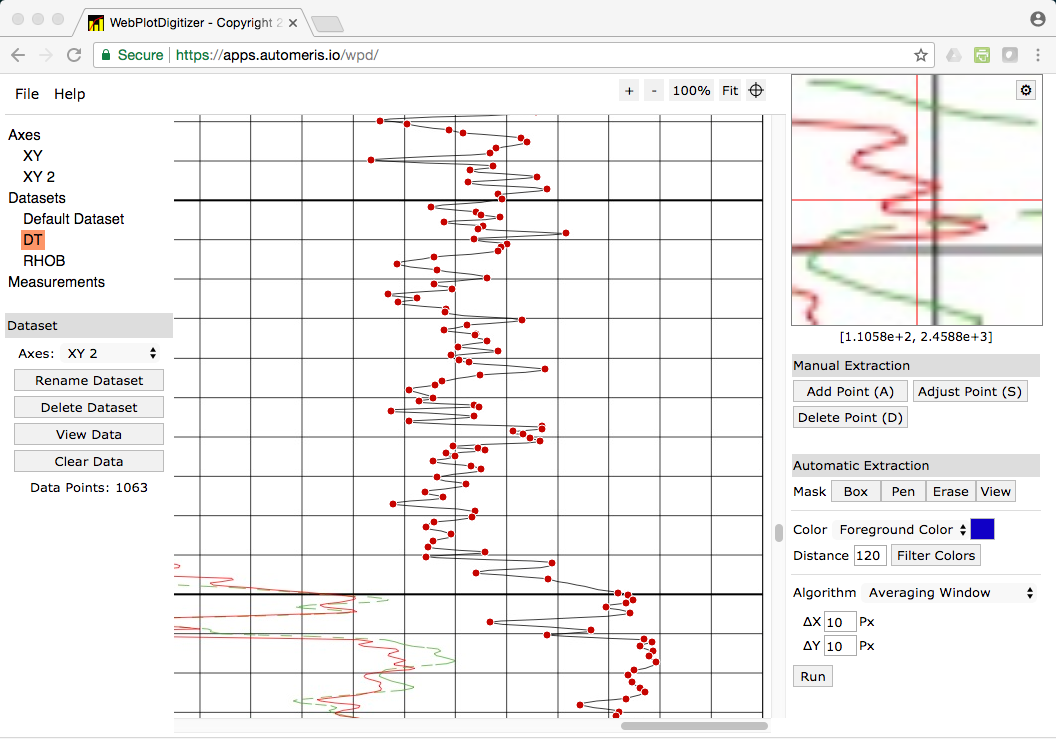

In [2]:
img('Resampling_data/web-plot-digitizer.png')

Now, I import the digitized data here.

In [3]:
file_data = np.loadtxt('Resampling_data/DT_digitalizado.csv', delimiter=',')
print(file_data)

[[  97.78387015 1783.61793255]
 [ 107.66242499 1783.9673913 ]
 [ 122.74967239 1784.54982257]
 ...
 [  67.53282024 2527.13011039]
 [  69.97301467 2528.10401185]
 [  69.59760015 2528.71270026]]


In [4]:
file_data[0,1]    # checking the first value for the DEPTH of the log

1783.6179325460753

In [5]:
DEPT_DT = file_data[:,1]    # assigning the second collumn to a parameter
DEPT_DT

array([1783.61793255, 1783.9673913 , 1784.54982257, ..., 2527.13011039,
       2528.10401185, 2528.71270026])

In [7]:
log = las.LASReader('Resampling_data/1RJS_0426__RJ_1RJS_0426__RJ_BCS_00027.las')     # reading the DT log I already have
log.data

array([(2521.0496, 53.3044), (2521.202 , 53.5918), (2521.3544, 53.822 ),
       ..., (3669.6884, 67.23  ), (3669.8408, 67.1271),
       (3669.9932, 67.1921)], dtype=[('DEPT', '<f8'), ('DT', '<f8')])

In [7]:
# note that this log starts at the DEPTH 2521.0496 

In [8]:
log.step     # sampling interval of the logs stores at the .las file

0.1524

In [9]:
log.start    # value of the starting DEPTH of the log

2521.0496

## Resampling the data according to the log.step

In [10]:
a = np.arange(log.start-log.step, file_data[0,1], -log.step)
a

array([2520.8972, 2520.7448, 2520.5924, ..., 1784.0432, 1783.8908,
       1783.7384])

In [11]:
DEPT = np.sort(a, axis=None)
DEPT

array([1783.7384, 1783.8908, 1784.0432, ..., 2520.5924, 2520.7448,
       2520.8972])

In [12]:
DEPT.size

4838

Now, using spline algorithm from Scipy module I will atribute intermediate values for the interval resampled. 


In [13]:
DEPT_DT = file_data[:,1]    # Depth parameter distributed unevenly that came from the file digitized
DEPT_DT.size   # number os samples

1519

In [14]:
DT = file_data[:,0]         # DT values from the digitized log
DT

array([ 97.78387015, 107.66242499, 122.74967239, ...,  67.53282024,
        69.97301467,  69.59760015])

In [15]:
DT.size

1519

## Interpolation Spline 1d 

In [16]:
import matplotlib.pyplot as plt
from scipy import interpolate
x = DEPT_DT
y = DT
f = interpolate.interp1d(x, y)

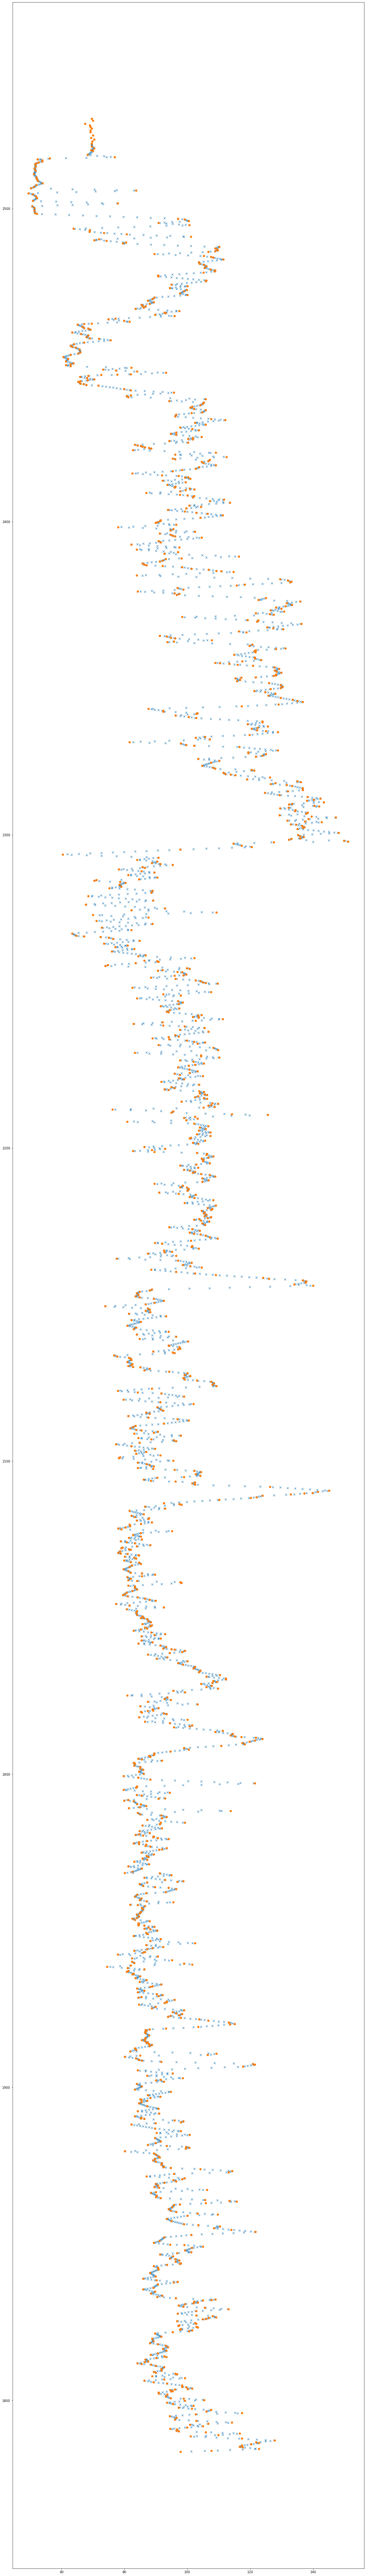

In [17]:
xnew = DEPT      # profundidade reamostrada
ynew = f(xnew)   # use interpolation function returned by `interp1d`

plt.figure(figsize=(20,150))
plt.plot(ynew, xnew, 'x', y, x, 'o')
plt.show()

In [18]:
DT_upsampled = ynew
DT_upsampled[:15]

array([101.18926299, 105.49733003, 109.62616668, 113.57392266,
       117.52167863, 121.46943461, 121.59851126, 119.89486657,
       118.19122188, 117.17773754, 116.67101235, 116.98432632,
       117.29764029, 118.11012326, 119.05006516])

Ready! 

## Exporting the result in a .las file:

In [19]:
las_file = ('Resampling_data/1RJS_0426__RJ_1RJS_0426__RJ_BCS_00027.las')

In [20]:
log0 = lasio.read(las_file)
        
well_name = str(log0.well.well.value)
well_name = well_name.replace(" ", "")

In [21]:
orig_stdout = sys.stdout
sys.stdout=open(well_name+'-DT_digitized.las','w')

In [22]:
with open(las_file, 'r') as f:
    for line in f:
        if line.lstrip().startswith('~C'):
            break
        f = np.append(f, (line.rstrip()))
        print(line.rstrip())

Exporting the data to a file:

In [23]:
Depth = np.array([DEPT])
Depth.T

array([[1783.7384],
       [1783.8908],
       [1784.0432],
       ...,
       [2520.5924],
       [2520.7448],
       [2520.8972]])

In [24]:
dt = np.array([DT_upsampled])
dt.T

array([[101.18926299],
       [105.49733003],
       [109.62616668],
       ...,
       [ 69.59760015],
       [ 69.59760015],
       [ 69.62264293]])

In [25]:
DT_log = np.concatenate((Depth.T, dt.T), axis=1)
DT_log

array([[1783.7384    ,  101.18926299],
       [1783.8908    ,  105.49733003],
       [1784.0432    ,  109.62616668],
       ...,
       [2520.5924    ,   69.59760015],
       [2520.7448    ,   69.59760015],
       [2520.8972    ,   69.62264293]])

In [27]:
np.savetxt('DT_log_digitized_RJS-426.txt', DT_log, fmt='%s', delimiter=' ', newline='\n', header='', footer='', comments='# ') 

Adding the data to the .las file:

In [28]:
sys.stdout=open(well_name+'-DT_digitized.las','a')
print ('~Curve Information Block') 
print ('DEPTH.M                                                  :     1  DEPTH') 
print ('DT.                                                      :     2  Sonic delta_T') 
print ('~ASCII.                                                                       ')

In [31]:
with open('DT_log_digitized_RJS-426.txt', 'r') as data:
    for line in data:
        if line.lstrip().startswith('~A'):
            break
        data = np.append(data, (line.rstrip()))
        print(line.rstrip())



Changing the value of some parameters:

In [32]:
DEPTH_start = Depth[0]
DEPTH_end = Depth[-1]

In [33]:
l = lasio.read(well_name+'-DT_digitized.las')

In [34]:
l.well['STRT'] = lasio.HeaderItem('STRT', value=DEPTH_start)

In [35]:
l.well['STOP'] = lasio.HeaderItem('STOP', value=DEPTH_end)

In [36]:
l.write(well_name+'-DT_digitized.las')

In [37]:
l['DEPTH'][-1]

2520.8972

Now this .las file can be imported manually or automatically with the specific Jupyter Notebook.